# Ordinary and Simple Kriging

This tutorial will teach us how to perform spatial interpolation with Ordinary and Simple Kriging. We will compare Kriging behavior in relation to a different number of ranges, and finally check how number of neighbors changes the interpolation quality. Ordinary and Simple Kriging are the simplest form of Kriging, but they're still powerful, thus you should always start from those methods and then move to more sophisticated techniques.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging (basics)
- **Package**:
  - `TheoreticalVariogram`
  - `ExperimentalVariogram`
- **Programming**:
  - Python basics

## Table of contents

1. Set semivariogram model (**fit** data into semivariogram).
2. Create Ordinary and Simple Kriging models.
3. Predict values at unknown locations and compare predictions to test set.

## 1. Set semivariogram model (fit)


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pyinterpolate import (
    build_experimental_variogram,
    build_theoretical_variogram,
    ordinary_kriging,
    simple_kriging
)

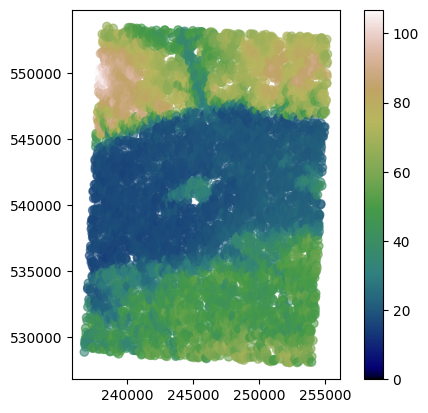

In [3]:
# Load DEM data

df = pd.read_csv(
    '../data/dem.csv'
)
# Populate geometry column and set CRS

dem_geometry = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='epsg:4326')
dem = gpd.GeoDataFrame(df, geometry=dem_geometry)

# Transform crs to metric values
dem.to_crs(epsg=2180, inplace=True)
dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

In the beginning, we remove 90 % of our points from the dataset, and we will leave them as a test set to calculate interpolation error of Kriging models.

> **Note**: probably you have realized, that we put much more records in test set than in classic machine learning. This simulates real-world problems where we have only few samples and we must deliver a large surface of predicted values.

In [11]:
train = dem.sample(n=int(0.1*len(dem)))
test = dem.loc[~dem.index.isin(train.index)]

In [12]:
len(train), len(test), len(dem) - (len(train) + len(test))

(689, 6206, 0)

,longitude,latitude,dem,geometry
6375,15.350970,52.664754,22.514732,POINT (253337.708 539475.975)
6387,15.351761,52.750242,81.235672,POINT (253873.114 548974.65)
2794,15.216889,52.736167,67.476715,POINT (244695.206 547880.504)
6848,15.368768,52.702013,21.342001,POINT (254749.391 543556.19)
4658,15.286500,52.638880,37.777115,POINT (248833.019 536823.177)


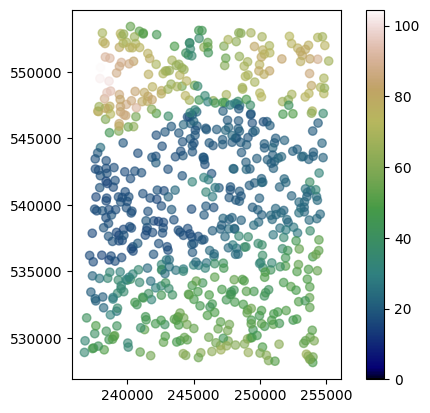

In [14]:
train.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);
train.head()

We have removed a subset of points from a dataset to be sure that Kriging is working. In this scenario, 90% of available points are removed, but in real-world cases, you will probably have even fewer points to perform estimations, down to the ~1% of known values.

We have two variables right now:

- `train`: training set used for semivariogram model derivation,
- `test`: test set used for the model error calculation.

The worst idea is to take sample as `k first values` from the list. Let's imagine we have a sorted list of Digital Elevation Model points. The western part of our measurements covers a mountain, and the eastern part is plain. When we use the part of the west for modeling and the east part for tests, we are going directly into a catastrophe! **Points for each set are chosen randomly** to avoid bias related to the geographical location, but we cannot be sure that the sampled points are not from the neighborhood, thus in a fully controlled scenario we perform this experiment multiple times sampling dataset dozens or hundreds of times.

Having datasets, we can start modeling. Kriging requires fitted theoretical semivariogram.

In [16]:
step_size = 500  # meters
max_range = 10000  # meters

exp_var = build_experimental_variogram(
    ds=train[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

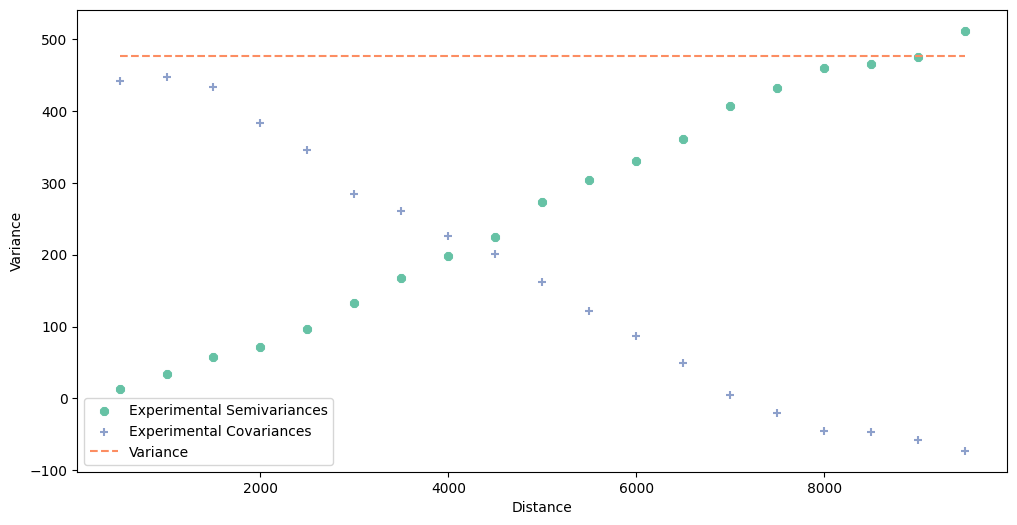

In [17]:
exp_var.plot();

In [18]:
theo_var = build_theoretical_variogram(
    experimental_variogram=exp_var,
    models_group='linear'
)

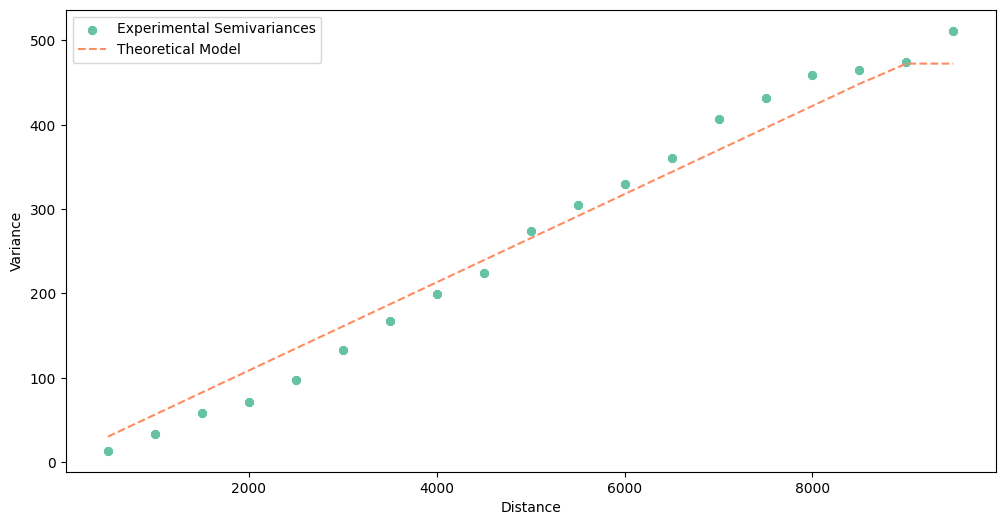

In [19]:
theo_var.plot()

In [20]:
print(theo_var)

* Selected model: Linear model
* Nugget: 4.0462240213206835
* Sill: 468.4823269705579
* Range: 8959.220565896268
* Spatial Dependency Strength is strong
* Mean Bias: None
* Mean RMSE: 25.48613867902546
* Error-lag weighting method: equal


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |   bias (real-yhat)  |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 30.19148540454077  | 13.487413404402279 | -16.704072000138492 |
| 1000.0 | 56.33674678776086  | 33.878438284929565 | -22.458308502831294 |
| 1500.0 | 82.48200817098095  | 58.11007694268844  |  -24.37193122829251 |
| 2000.0 | 108.62726955420104 | 71.07661945884396  |  -37.55065009535707 |
| 2500.0 | 134.77253093742112 | 96.94475768093871  | -37.827773256482416 |
| 3000.0 | 160.9177923206412  | 132.57130638000604 | -28.346485940635176 |
| 3500.0 | 187.0630537038613  | 167.1015672456457  | -19.961486458215603 |
| 4000.0 |

## 2. Create Ordinary and Simple Kriging models